# Анализ данных зарплате, работе и гендере в США 

импортируем необходимые библиотеки

In [1]:
import pandas as pd 
import numpy as np  
import seaborn as sns


### а что в табличке?
Читаем наши данные, чистим от na
Как видим, в таблице 7 столбцов: название профессии, общее количество работников, средняя недельная з.п. среди всех работников, количество мужчин и женщин работников соотвественно и их средняя з.п.\нед. 

In [3]:
data_folder = 'data/'  # Папка с данными 
dat = pd.read_csv(data_folder + 'datasets_187_404_inc_occ_gender.csv')
dat=dat.replace('Na',pd.NaT,) #иначе dropna() работать не будет, т.к. none в таблице обозначили текстом
dat=dat.dropna() 
dat.head()


,Occupation,All_workers,All_weekly,M_workers,M_weekly,F_workers,F_weekly
0,ALL OCCUPATIONS,109080,809,60746,895,48334,726
1,MANAGEMENT,12480,1351,7332,1486,5147,1139
2,Chief executives,1046,2041,763,2251,283,1836
3,General and operations managers,823,1260,621,1347,202,1002
6,Marketing and sales managers,948,1462,570,1603,378,1258


## занимательная статистика
Попробуем выяснить, какие профессии самые оплачиваемые, и какому из полов платят больше

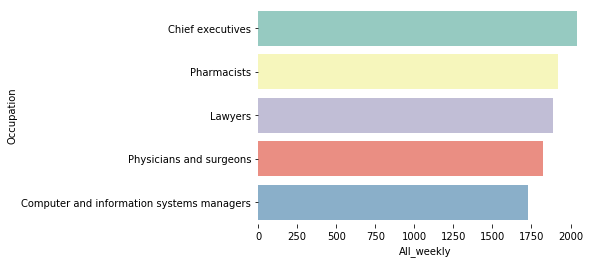

In [5]:
sns.set_palette("Set3") #чисто чтобы не так грустно было
dat['All_weekly']=dat['All_weekly'].astype(int) #иначе глупый панадас не понимает, что это числа и сортирует некорректно
result = dat.sort_values(by=['All_weekly'], ascending=False) #сортируем график по колонке с общей з.п./нед.

ax = sns.barplot(x='All_weekly', y='Occupation', data=result.head())
sns.despine(left=True, bottom=True)


Как мы видим, самым оплачиваемым оказался труд: **начальников, фармацевтов, юристов, врачей и хирургов а так же сисадминов(по какой-то причине)** . Крайне занимательно.

In [9]:
all_m_inc=np.sum([int(i) for i in dat['M_weekly']]) #доход мужчин всех проффессий
all_f_inc=np.sum([int(i) for i in dat['F_weekly']]) #доход женщин всех проффессий


Считаем общий доход мужчин и женщин всех профессий, смотрим, кто богаче...

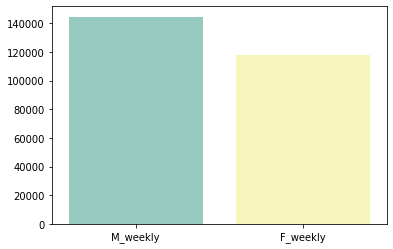

In [11]:
x=np.array(['M_weekly','F_weekly'])
y=np.array([all_m_inc,all_f_inc])
ax = sns.barplot(x=x, y=y)

Как я и предполагал... США растлена токсичными соками патриархата(не удивительно, с таким-то президентом). Из графика ясно, что мужчины в среднем зарабатывают гораздо больше

## Попробуем найти закономерности
### пол по зарплате
Для начала попрую посмотреть, можем ли мы предсказать по одной лишь зарплате человека его пол. Скорее всего, не можем, вот и посмотрим.
Для этого составлю список, где сначала идет столько 0, сколько работ, где заняты мужчины, а затем столько едениц, сколько работ, где заняты женщины(на самом деле, полсе удаления none это одинаковые числа). Это список лейблов, которое являются нашей целью.
В качестве параметра возьму список, склеенный из всех зарплат мужчин и женщин.

In [34]:
m=list('0'*len(dat['M_weekly']))  
f=list('1'*len(dat['F_weekly']))
m,f=[int(i) for i in m],[int(i) for i in f]
m_inc=list(dat['M_weekly'].astype(int))
f_inc=list(dat['F_weekly'].astype(int))

target=np.array(m+f)
train=np.array(m_inc+f_inc).reshape(-1, 1)

Теперь я использую **train_test_split**, чтобы разделить выборку на тестовые и тренировочные подвыборки в пропорции 1 к 4

In [58]:
from sklearn.model_selection import train_test_split
tr_train, tr_test, ta_train, ta_test = train_test_split(train, target, test_size=0.25)

нормализую данные, чтобы все было красиво 

In [59]:
from sklearn import preprocessing

tr_train,tr_test = preprocessing.normalize(tr_train),preprocessing.normalize(tr_test)


Попробую создать 4 модели на основе 4ёх основных классификаторов, чтобы потом посмотреть, какой из них будет работать лучше. Конечно существуют штуки вроде RandomizedSearchCV, позволяющие перебирать параметры моделей и выявлять лучшие, но в данном случае, мне кажется, я и руками неплохо подобрал, да и сложно это...

Импортирую модули классификаторов

In [20]:
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

In [63]:
model_rfc = RandomForestClassifier(n_estimators = 70) #количество деревьев
model_knc = KNeighborsClassifier(n_neighbors = 18) #количество соседей
model_lr = LogisticRegression(penalty='l1', tol=0.01, solver='liblinear') 
model_svc = svm.SVC(kernel='linear') #с linear ядром в моем случае работает лучше, чем с стандартным rbf или poly, гамму и c не трогал, т.к. при изменении работает только хуже


Теперь я хочу использовать **cross_val_score()** чтобы посичтать счета точности моих моделей на моих данных при помощи 5-кросс-валидации  

импортирую функцию 

In [27]:
from sklearn.model_selection import cross_val_score

Задаю колличетсво разбиений 5, чтобы валидация была реально 5-перекресной, среди каждого из считов беру самое большое значение и сохраняю его в словать **best_sc**

In [64]:
kfold = 5
best_sc = {} 
scores1 = cross_val_score(model_rfc, train, target, cv = kfold)
best_sc['RandomForestClassifier'] = scores1.mean()
scores2 = cross_val_score(model_knc, train, target, cv = kfold)
best_sc['KNeighborsClassifier'] = scores2.mean()
scores3 = cross_val_score(model_lr, train, target, cv = kfold)
best_sc['LogisticRegression'] = scores3.mean()
scores4 = cross_val_score(model_svc, train, target, cv = kfold)
best_sc['SVC'] = scores4.mean()

Посмотрим результаты на графике 

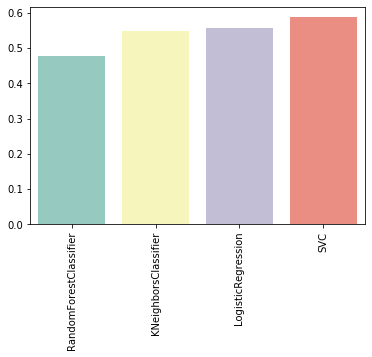

In [32]:
ax3=sns.barplot(x=list(best_sc.keys()), y=list(best_sc.values()))
for i in ax3.get_xticklabels():
    i.set_rotation(90)

В нашем случае молодцом оказалась модель на основе метода опроных векторов, посмотрю, какую точность мы получили 

In [33]:
("Accuracy: %0.2f (+/- %0.2f)" % (scores4.mean(), scores4.std() * 2))

'Accuracy: 0.59 (+/- 0.12)'

Точность, конечно, не впечатляет. Получается, мы не может по-человечески предскзать пол человека по его зарплате(без знания профессии разумеется), что, впрочем, совсем неудивительно.

### преобладание женщин или мужчин в профессии
Попробую придумать более логичную закономерность: что если посчитать, зависит ли преобладаение одного из полов в профессии от имеющихся параметров, и как.
Создаю выборки.
На этот раз для разнообразия попробую взять несколько фич: общий доход, кол-во всех работников, разница доходов.

In [39]:
m_inc=list(dat['M_weekly'].astype(int)) # доход мужчин
f_inc=list(dat['F_weekly'].astype(int)) # доход женщин
inc_dif=[np.absolute(m_inc[i]-f_inc[i]) for i in range(len(m))] # разница доходов
m_n=list(dat['M_workers'].astype(int))
f_n=list(dat['F_workers'].astype(int))
n_dif=[1*(m_n[i]>f_n[i]) for i in range(len(m_n))] #массив с 0 и 1, где 1, если мужчин в профессии больше женщин
all_worc=list(dat['All_workers'].astype(int)) # кол-во всех работников
all_inc=list(dat['All_weekly'].astype(int)) # общий доход
tr_dat=pd.DataFrame(data={'inc_dif':inc_dif,'all_worc':all_worc,'all_inc':all_inc}) # формируем табличку 


In [43]:
target=np.array(n_dif)
train=np.array(tr_dat.values)

Давайте посмотрим, какая из наших фич имеет наибольшую предсказательную ценность.Буду отбирать фичи на случайном лесу, потому что так удобнее. Предварительно заранив ячейки с разбиением на тестовую и учебную выборку, нормализацией.

In [46]:
from matplotlib import pyplot


[0.36099121 0.32936757 0.30964121]


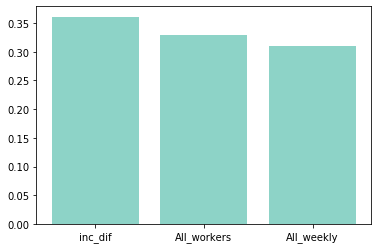

In [47]:
model_rfc = RandomForestClassifier(n_estimators = 70)
model_rfc.fit(tr_train, ta_train)
my_features = list(('inc_dif','All_workers','All_weekly'))
importance = model_rfc.feature_importances_
print(importance)
pyplot.bar([my_features[x] for x in range(len(importance))], importance)
pyplot.show()

И вновь я не удивлен резульатом, ведь мой самый **логичный**, самый прекрасный параметр, который я сам придумал, оказался наиболее значимым. Чтожб, используем именно его для дальнейших предсказаний(я пытался включить также All_workers, но результаты стали только хуже)

Распределяем таргет с трейном заново, потом опять запускаем ячейки с train_test_split и нормализацией, а потом с кроссвалидацией

In [57]:
target=np.array(n_dif)
train=np.array(tr_dat['inc_dif']).reshape(-1, 1)

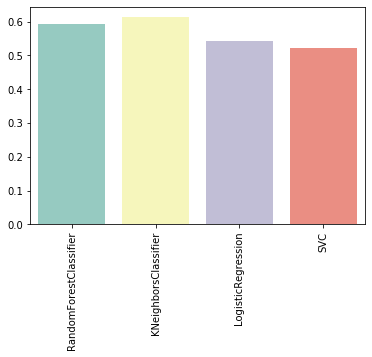

In [65]:
ax3=sns.barplot(x=list(best_sc.keys()), y=list(best_sc.values()))
for i in ax3.get_xticklabels():
    i.set_rotation(90)


На этот раз лучше всех оказался метод ближайших соседей. Посмотрим, какая там у него точность...

In [69]:
("Accuracy: %0.2f (+/- %0.2f)" % (scores2.mean(), scores2.std() * 2))

'Accuracy: 0.61 (+/- 0.10)'

В принципе, чуть менее ужасно, чем с предыдущей зависимостью, наша точность достигает аж 71... Да, это позорный резульат, но я не уверен, что из этих данных можно выжать больше. 
Для полученой модели можно было бы простроить roc кривую, или персижн-рекол, но для случая, когда используется одна фича - смысла немного . 


# сегодня я многое понял
В США:
* женщины зарабатывают меньше мужчин
* глупо предсказывать пол человека по его зарплате, без знания профессии, сексисты
* есть некоторая(хилая) зависимость между преобладанием одного из полов и разницей в оплате их труда